In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from dataset import RotatedSquaresDataset

## Dataset

In [3]:
db = RotatedSquaresDataset()
imgs, labels = db.generate_batch(num=2, h=50, w=30)

## Encoding

In [4]:
from functions import *
from tests import *

In [5]:
# imgs_down, labels_down = downsample(imgs, labels)
# gt_class, gt_loc = encode_y(imgs_down, labels_down)

In [6]:
# import matplotlib.pyplot as plt
# for b in range(gt_loc.shape[0]):
#     for c in range(4):
#         # Distplay image
#         show_image(gt_loc[b,c,:,:].data, "img_%d_c_%d"%(b,c))
        
#         # Display histogram over pixels to verify that everything is working fine
#         plt.hist(gt_loc[b,c,:,:].data.ravel())
#         plt.show()

## Training

In [7]:
import chainer
from dataset import SquaresDataset
import matplotlib.pyplot as plt
import numpy as np
from functions import *
from tests import *
from chainer import cuda 
import cupy
from chainer.optimizers import MomentumSGD,Adam 

In [8]:
from network import VGGNet
net = VGGNet()
net.to_gpu(0)

# Optimizer
# optimizer =MomentumSGD(lr= 0.05)
optimizer = Adam(alpha= 0.0001)
optimizer.setup(net)

  0%|          | 0/500 [00:00<?, ?it/s]

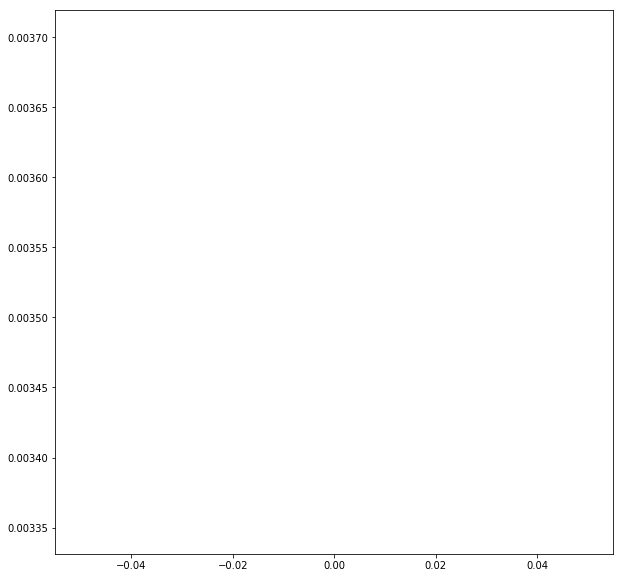

 10%|█         | 50/500 [00:15<02:12,  3.39it/s]

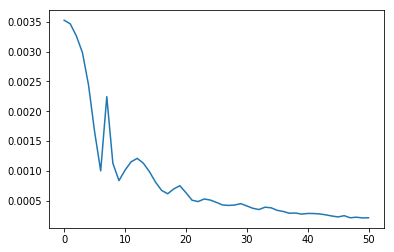

 20%|██        | 100/500 [00:30<01:58,  3.38it/s]

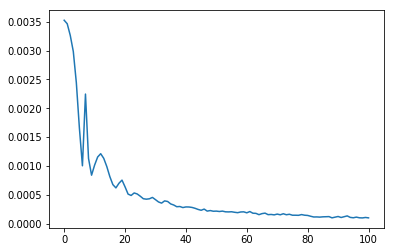

 30%|███       | 150/500 [00:45<01:43,  3.38it/s]

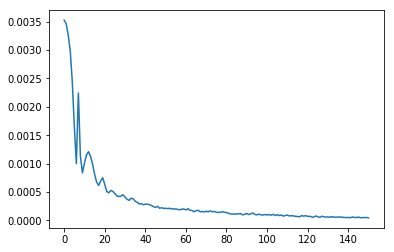

 40%|████      | 200/500 [01:00<01:28,  3.37it/s]

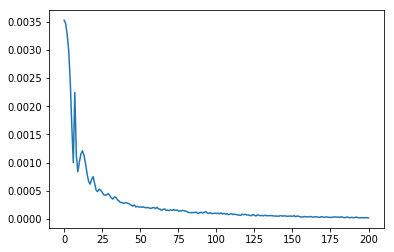

 50%|█████     | 250/500 [01:15<01:14,  3.38it/s]

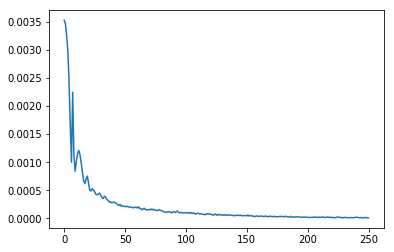

 60%|██████    | 300/500 [01:30<00:59,  3.37it/s]

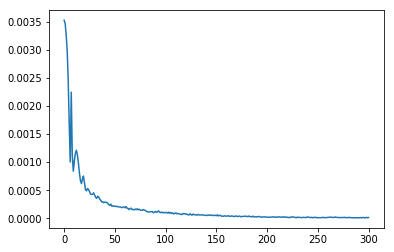

 70%|███████   | 350/500 [01:45<00:44,  3.37it/s]

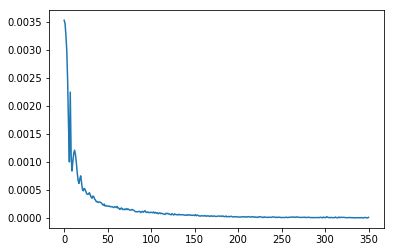

 80%|████████  | 400/500 [02:00<00:29,  3.37it/s]

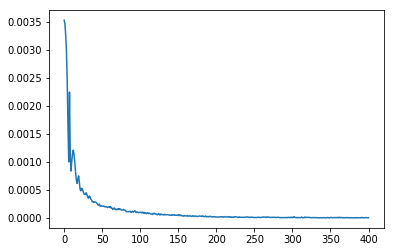

 90%|█████████ | 450/500 [02:15<00:14,  3.38it/s]

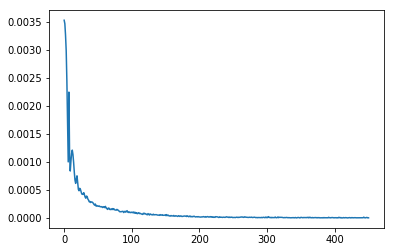

100%|██████████| 500/500 [02:30<00:00,  3.37it/s]


In [9]:
from tqdm import tqdm
losses = []

plt.figure(figsize=(10,10))
dimensions =[50,30]

# Training for loop
for i in tqdm(range(500)):
    imgs, labels = db.generate_batch(num=10, h=dimensions[0], w=dimensions[1], image_size=240)
    imgs_down, labels_down = downsample(imgs, labels)
    
    net.to_gpu(0)

    imgs_gpu = chainer.Variable(cuda.to_gpu(imgs)) #gpu
    
    gt_class, gt_loc = encode_y(imgs_down, labels_down) #cpu
    
    gt_class.to_gpu(0)
    gt_loc.to_gpu(0)

    # Forward pass: SLOW!!!
    pred_class, pred_loc = net(imgs_gpu) #net(imgs) #gpu
    
    
   # Loss calculation
#     class_loss = classification_loss(pred_class, gt_class)

#     class_loss = regression_loss(pred_loc, gt_loc, gt_class)
    
    
    net_loss = loss(pred_class, pred_loc, gt_class, gt_loc, lambd=1.0)
    #print(net_loss.debug_print())
    #net_loss.to_gpu(0)
    
    # Update network
    net.zerograds()
    net_loss.backward()
    optimizer.update()
    
    # Print loss
    #show_image(pred_class.data[0,0,:,:], 'prediction output vgg')
    #
    #show_image(gt_class.data[0,0,:,:], 'class output vgg')
    losses.append(net_loss.data.get())
    
    #print(net_loss.data)
    if i % 50 == 0:
        plt.plot(range(len(losses)), losses)
        plt.show()
    
# Final loss plot


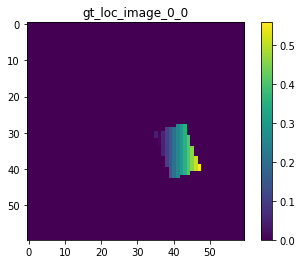

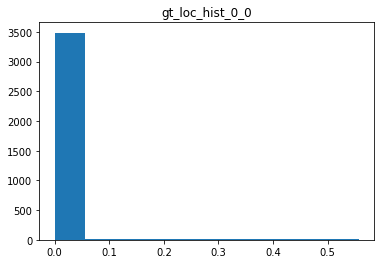

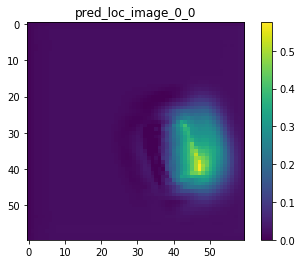

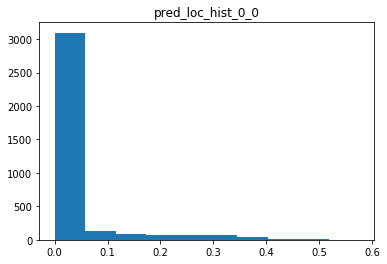

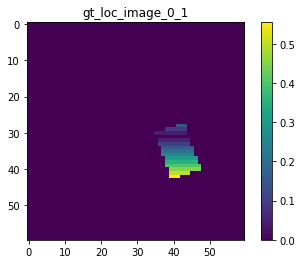

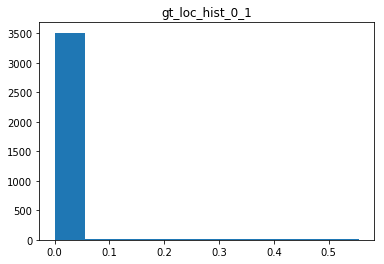

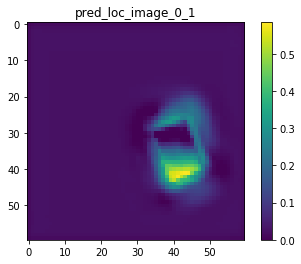

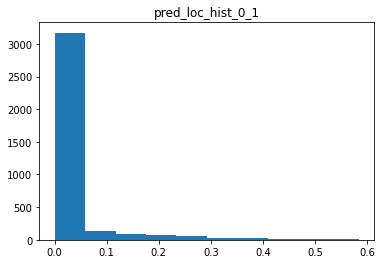

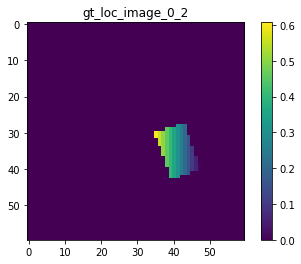

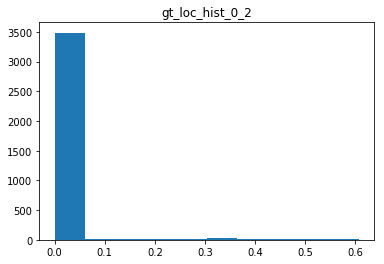

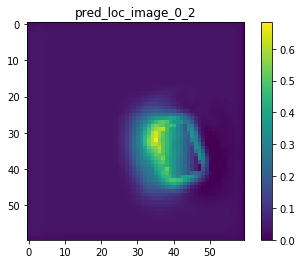

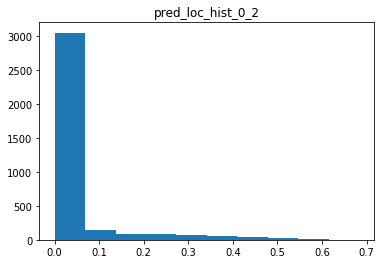

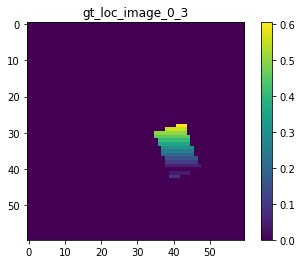

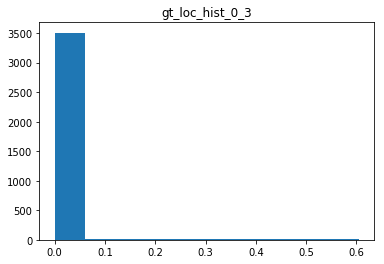

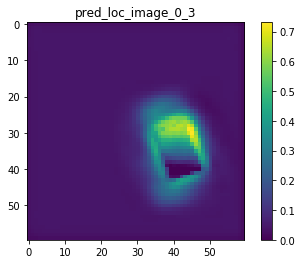

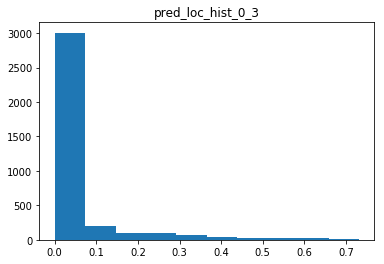

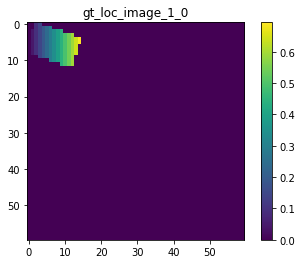

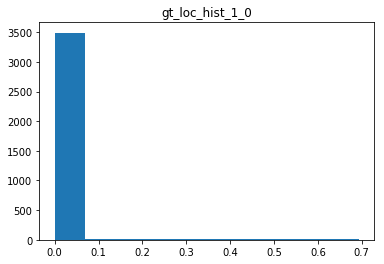

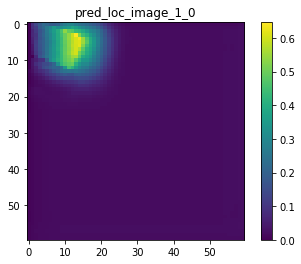

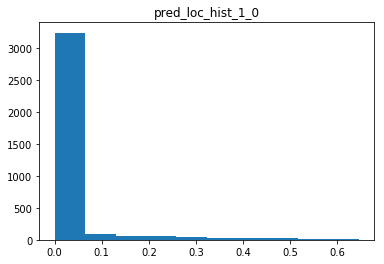

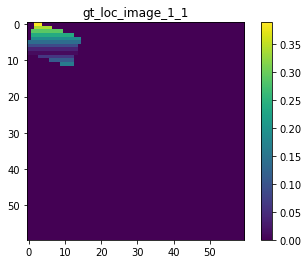

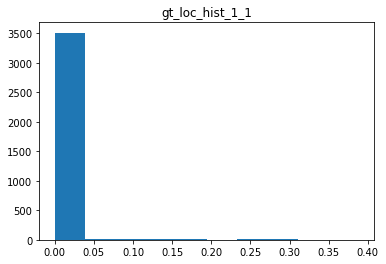

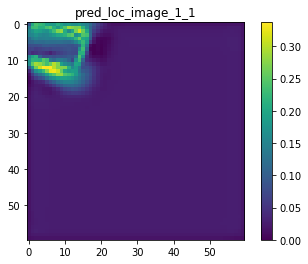

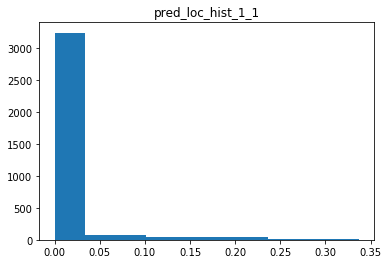

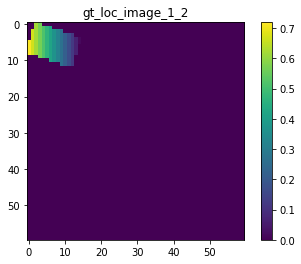

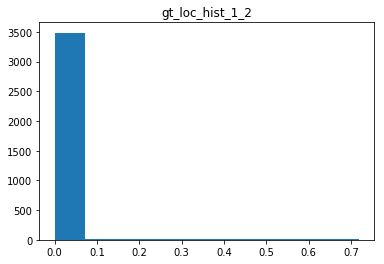

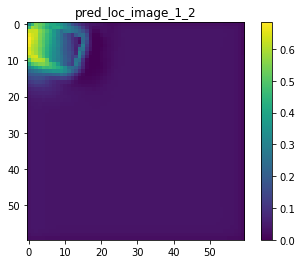

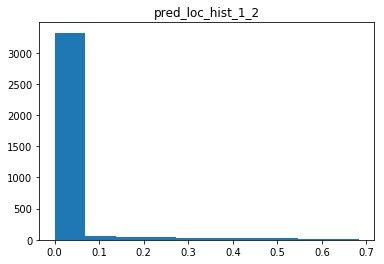

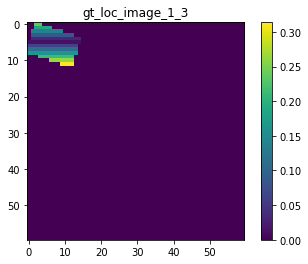

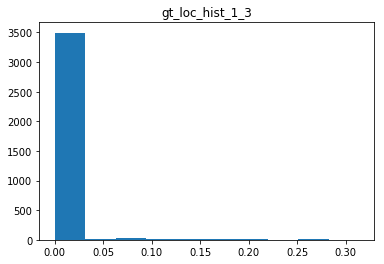

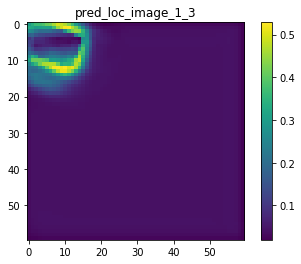

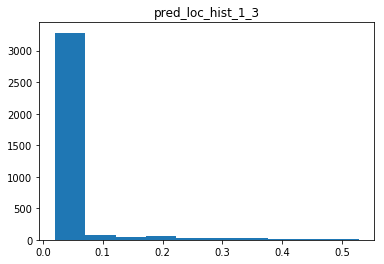

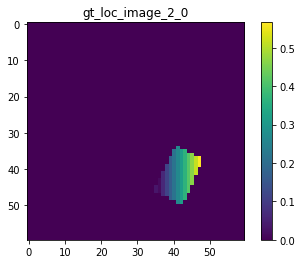

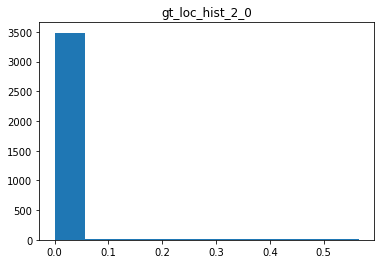

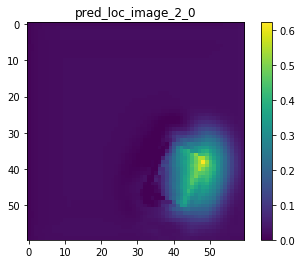

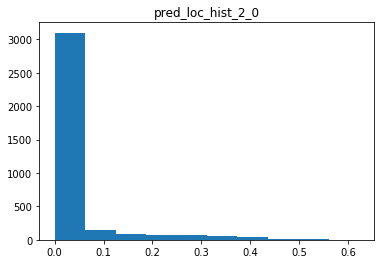

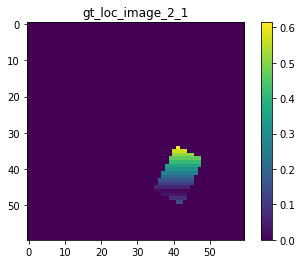

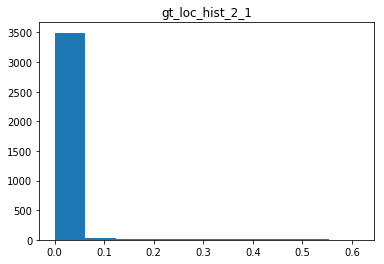

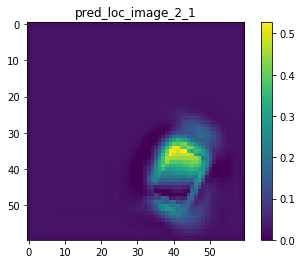

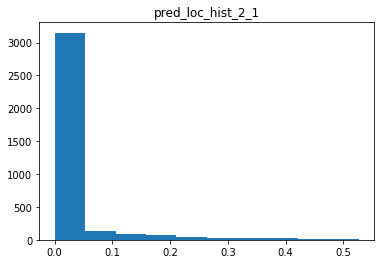

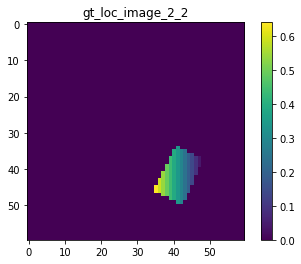

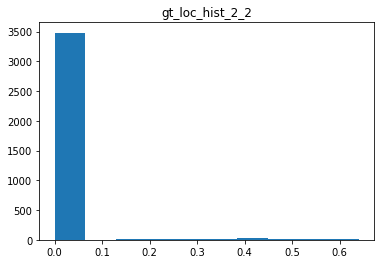

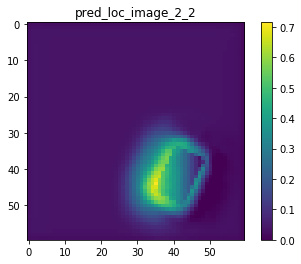

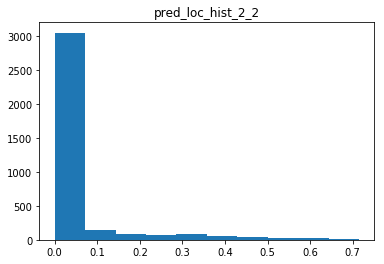

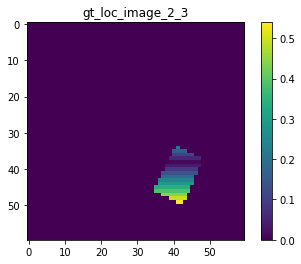

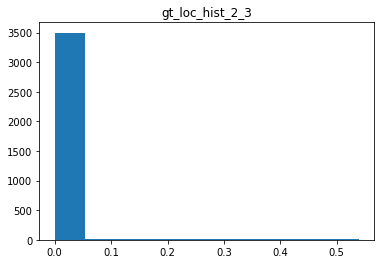

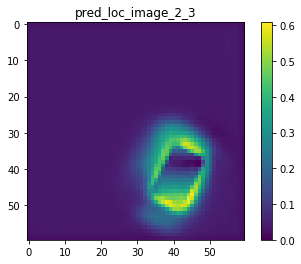

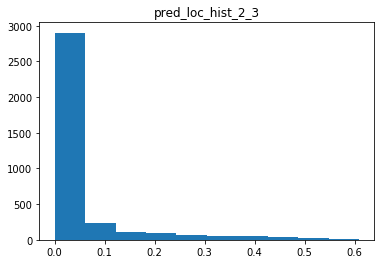

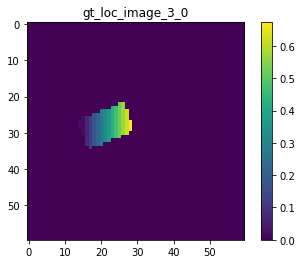

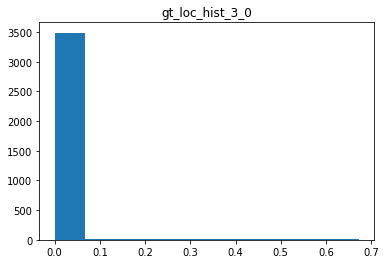

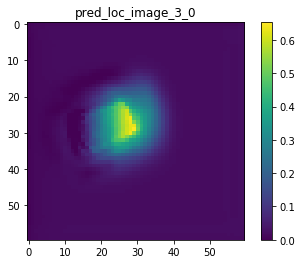

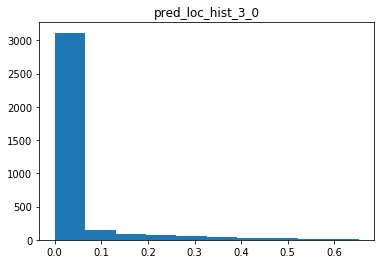

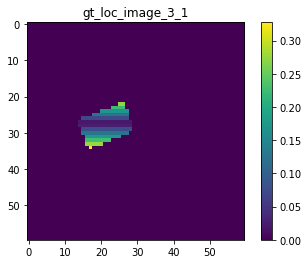

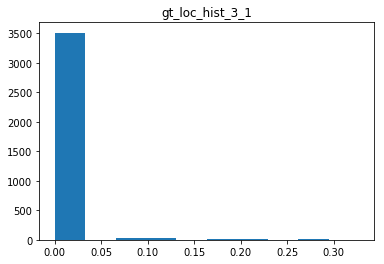

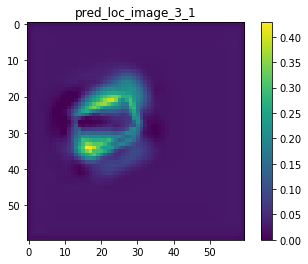

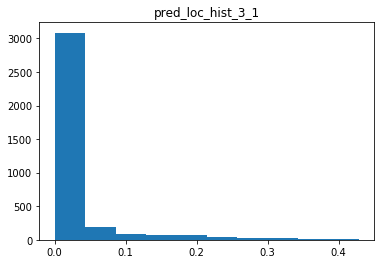

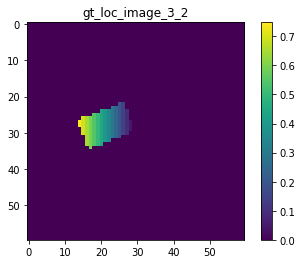

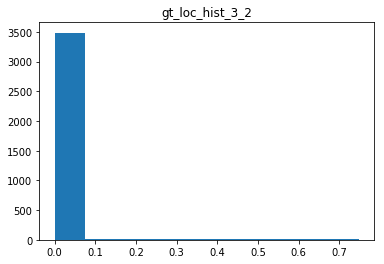

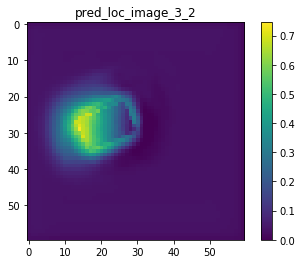

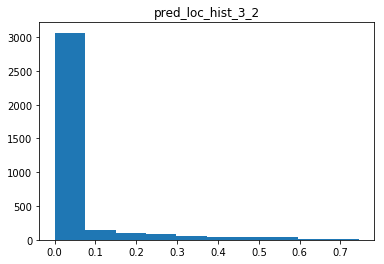

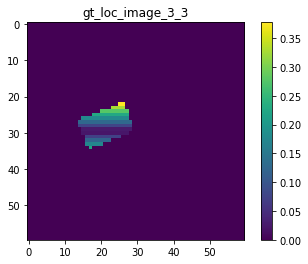

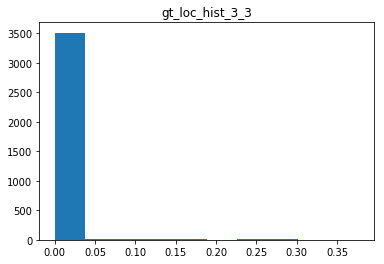

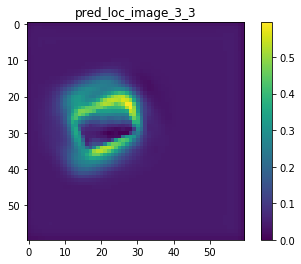

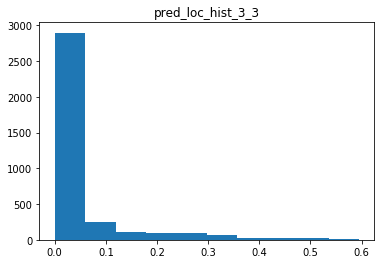

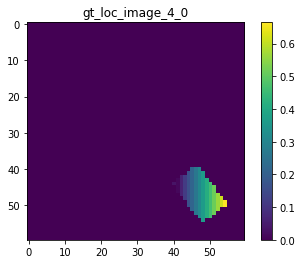

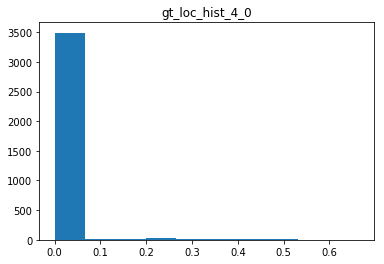

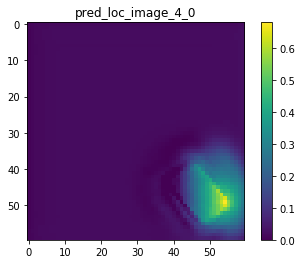

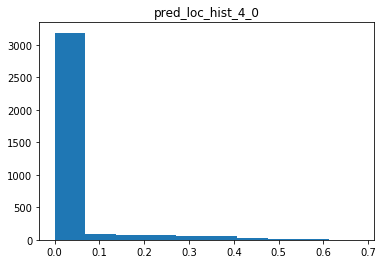

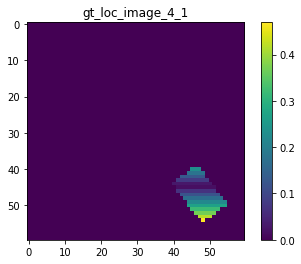

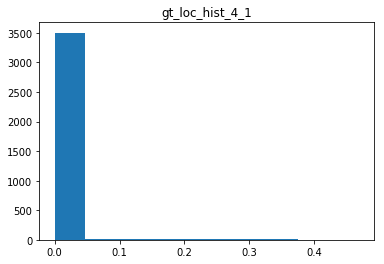

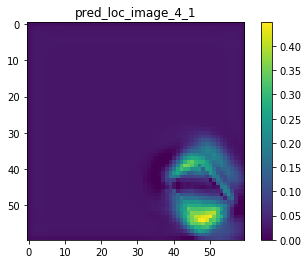

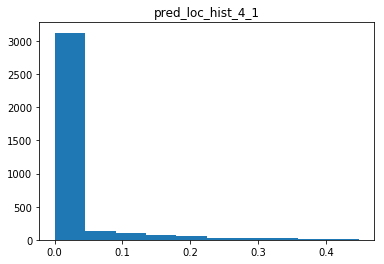

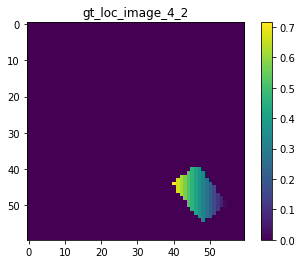

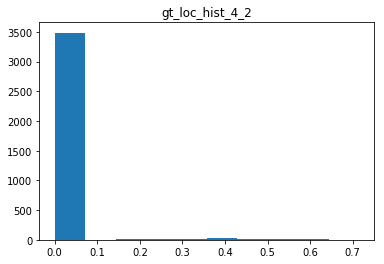

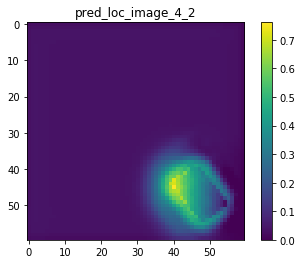

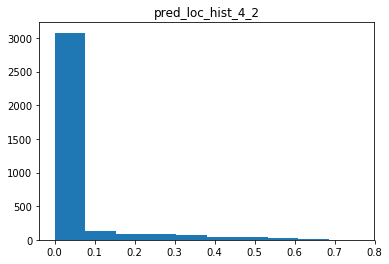

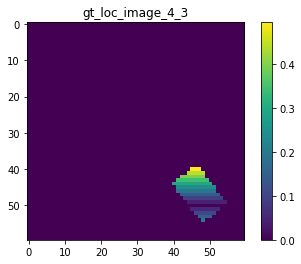

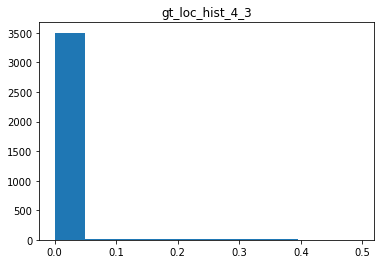

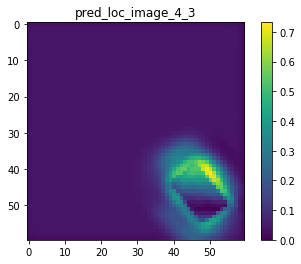

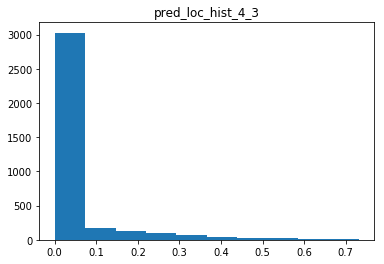

In [10]:
# db = SquaresDataset()
# imgs, labels = db.generate_batch(n=10, h=50, w=50, img_h=240, img_w=240)
# imgs_down, labels_down = downsample(imgs, labels)
gt_loc.to_cpu()
pred_loc.to_cpu()




for i in range(5):
    for c in range(4):
        plt.title("gt_loc_image_%d_%d"%(i, c))
        plt.imshow(gt_loc[i,c,:,:].data,)
        plt.colorbar()
        plt.show()
        
        plt.title("gt_loc_hist_%d_%d"%(i, c))
        plt.hist(gt_loc[i,c,:,:].data.ravel()) 
        plt.show()
        
        plt.title("pred_loc_image_%d_%d"%(i, c))
        plt.imshow(pred_loc[i,c,:,:].data)
        plt.colorbar()
        plt.show()
        
        plt.title("pred_loc_hist_%d_%d"%(i, c))
        plt.hist(pred_loc[i,c,:,:].data.ravel())
        plt.show()
    
        

[variable(37.46339416503906), variable(26.885347366333008), variable(45.080352783203125), variable(36.10029983520508)]


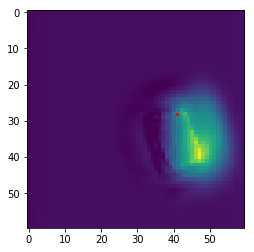

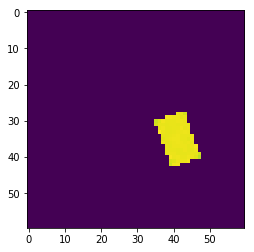

In [15]:
pred_class.to_cpu()
import matplotlib as mt 
pix_loc = [28,50]

pty, ptx = np.where(pred_class[0,0,:,:].data>0)

pix_x = ptx[0]
pix_y = pty[0]
single_box = pred_loc[0,:,pix_y,pix_x]

box_coordinates = [pix_x-12.5*single_box[0],
                           pix_y-12.5*single_box[1], 
                           pix_x+12.5*single_box[2], 
                            pix_y+12.5*single_box[3]]
print(box_coordinates)
plt.figure()
ax = plt.axes()
plt.imshow(pred_loc[0,0,:,:].data)
plt.scatter(ptx[0], pty[0], c='r', s=5)

plt.figure()
plt.imshow( pred_class[0,0,:,:].data)
plt.show()


In [12]:
np.unique(pred_class.data)

array([ 0.        ,  0.25530657,  0.73587811, ...,  1.03416324,
        1.03852248,  1.05210841], dtype=float32)